HEAD:
          Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0  2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1  2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2  2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3  2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4  2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN   

INFO:
<class

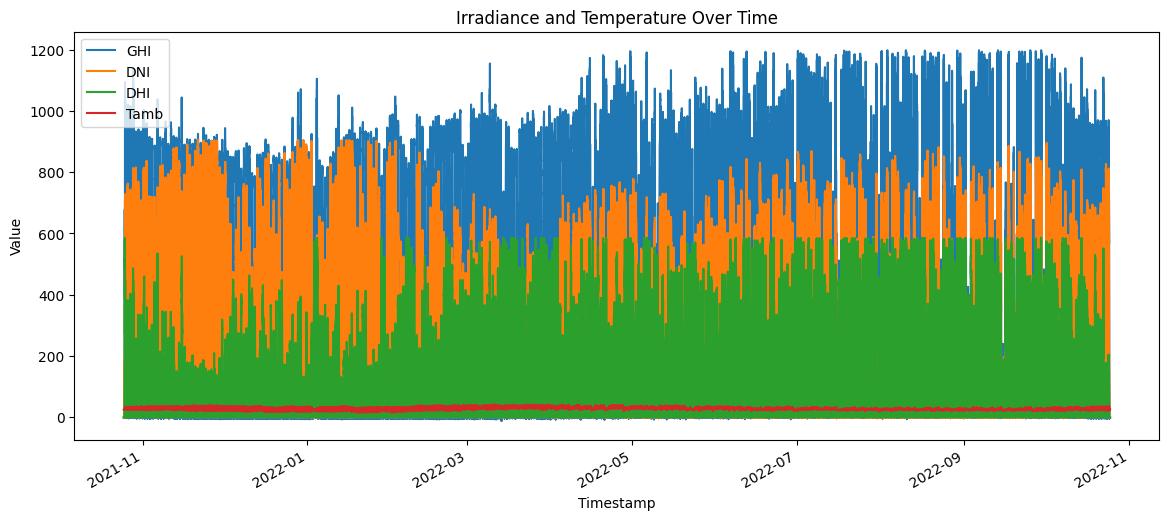

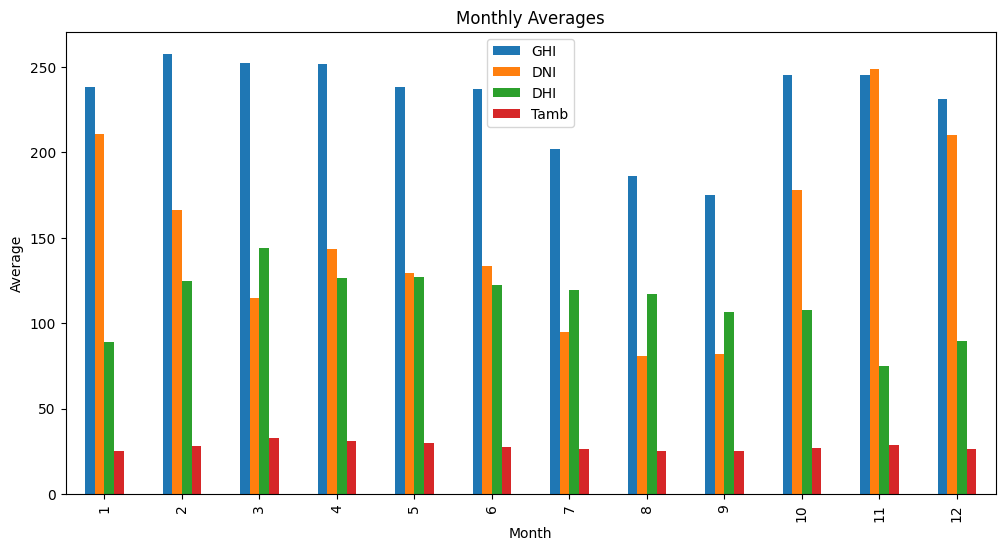

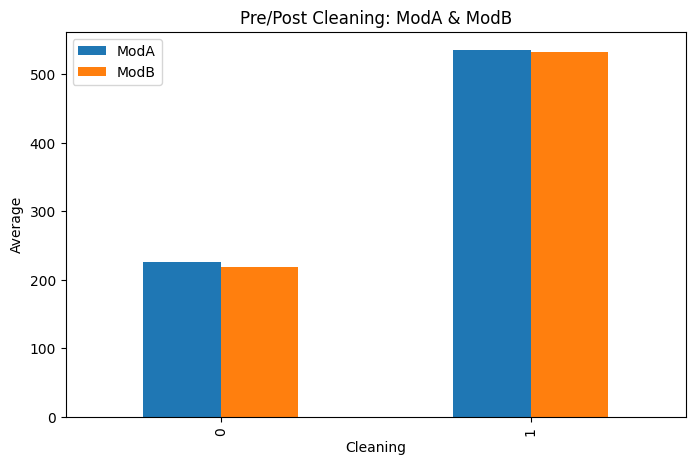

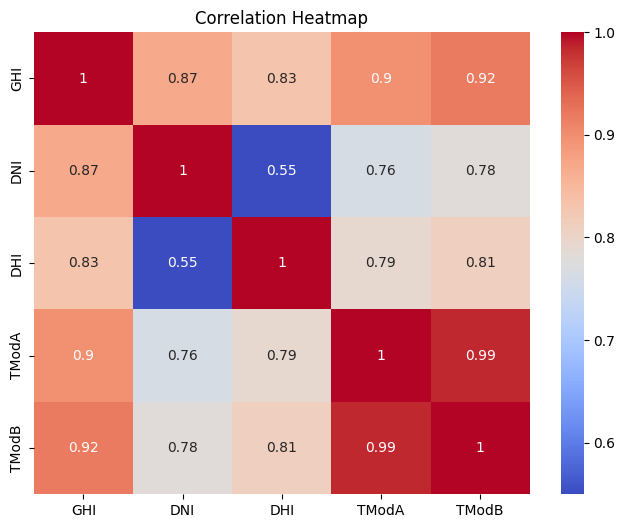

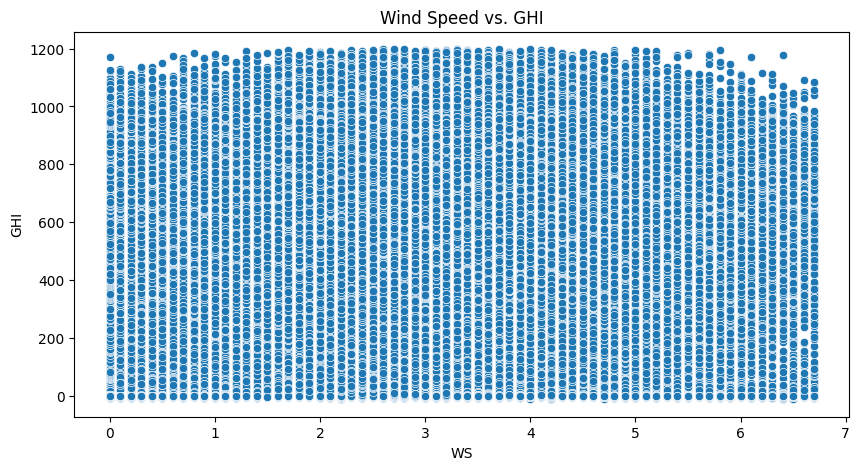

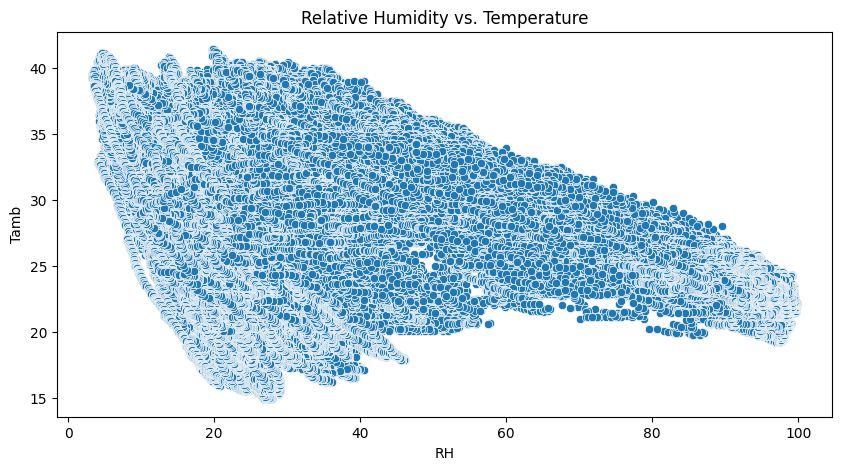

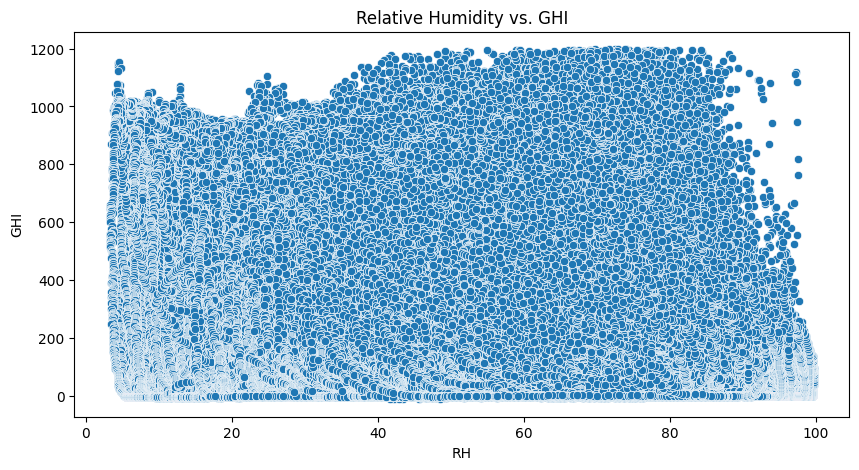

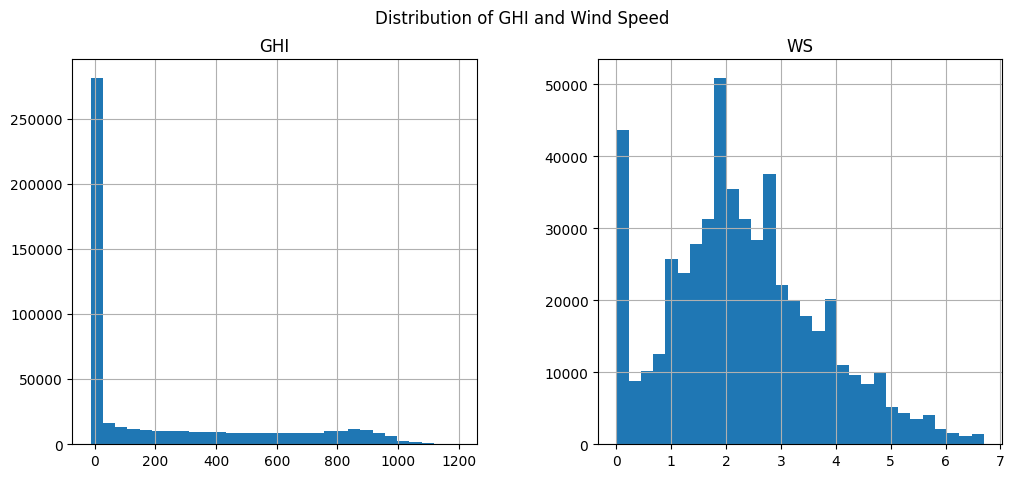

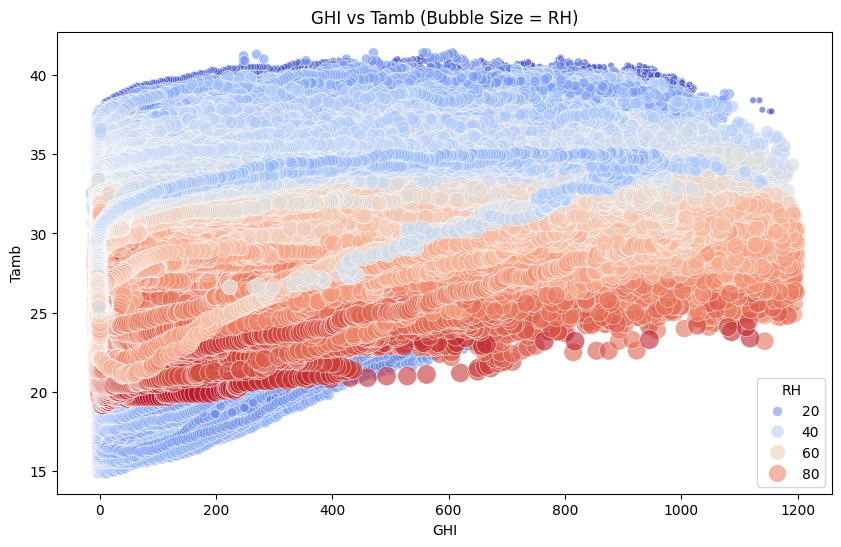

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

# =========================
# Step 1: Load and Clean Data
# =========================

class SolarDataCleaner:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.clean_df = self.df.copy()
        self.columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    def explore_raw_data(self):
        print("HEAD:")
        print(self.df.head(), "\n")
    
        print("INFO:")
        print(self.df.info(), "\n")
    
        print("DESCRIBE:")
        print(self.df.describe(), "\n")
    
        print("MISSING VALUES:")
        missing = self.df.isna().sum()
        missing_ratio = self.df.isna().mean()
        print("Count:\n", missing[missing > 0], "\n")
        print("Percentage:\n", (missing_ratio[missing_ratio > 0] * 100).round(2), "%\n")
    
        print("BASIC OUTLIER COUNT (Z-score > 3):")
        from scipy.stats import zscore
        z_scores = self.df[self.columns_to_check].apply(zscore)
        outliers = z_scores.abs() > 3
        outlier_rows = outliers.any(axis=1)
        print(f"Number of rows with at least one outlier: {outlier_rows.sum()}\n")

        print("BASIC INVALID ENTRIES CHECK:")
        invalids = (
            (self.df['Tamb'] < -50) | (self.df['Tamb'] > 90) |
            (self.df['TModA'] < -50) | (self.df['TModA'] > 90) |
            (self.df['RH'] > 100) |
            (self.df['WD'] > 360) |
            (self.df['WDstdev'] > 360) |
            (self.df['BP'] < 800) | (self.df['BP'] > 1100)
        )
        print(f"Rows with impossible values: {invalids.sum()}")

    def drop_useless_columns(self):
        if 'Comments' in self.clean_df.columns:
            self.clean_df.drop(columns=['Comments'], inplace=True)

    def validate_ranges(self):
        cond = (
            (self.clean_df['Tamb'] < -50) | (self.clean_df['Tamb'] > 90) |
            (self.clean_df['TModA'] < -50) | (self.clean_df['TModA'] > 90) |
            (self.clean_df['RH'] > 100) |
            (self.clean_df['WD'] > 360) |
            (self.clean_df['WDstdev'] > 360) |
            (self.clean_df['BP'] < 800) | (self.clean_df['BP'] > 1100) |
            (~self.clean_df['Cleaning'].isin([0, 1]))
        )
        self.clean_df = self.clean_df[~cond]

    def handle_outliers(self):
        z_scores = self.clean_df[self.columns_to_check].apply(zscore)
        outliers = z_scores.abs() > 3
        outlier_counts = outliers.sum(axis=1)

        #For outliers in columns greater than or equal to 3 per row, remove rows
        drop_idx = outlier_counts[outlier_counts >= 3].index
        self.clean_df.drop(index=drop_idx, inplace=True)

        #For remaining outliers (in rows with < 3 outlier columns), impute with column median
        for col in self.columns_to_check:
            mask = outliers[col]
            self.clean_df.loc[mask, col] = self.clean_df[col].median()

    def prepare_timestamp(self):
        self.clean_df['Timestamp'] = pd.to_datetime(self.clean_df['Timestamp'])

    def clean(self):
        self.drop_useless_columns()
        self.validate_ranges()
        self.handle_outliers()
        self.prepare_timestamp()
        return self.clean_df


# Load data
cleaner = SolarDataCleaner('../data/togo-dapaong_qc.csv')

# Explore data
cleaner.explore_raw_data()
# Clean data
df = cleaner.clean()

# Save cleaned data to a new file
df.to_csv('../data/togo-dapaong_qc_clean.csv', index=False)
# =========================
# Step 2: Feature Engineering
# =========================
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# =========================
# Step 3: Time Series Plot
# =========================
df.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(14, 6), title='Irradiance and Temperature Over Time')
plt.ylabel("Value")
plt.show()

# =========================
# Step 4: Monthly Averages
# =========================
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
monthly_avg.plot(kind='bar', figsize=(12, 6), title='Monthly Averages')
plt.ylabel("Average")
plt.show()

# =========================
# Step 5: Cleaning Effect on ModA & ModB
# =========================
df.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar', figsize=(8, 5), title='Pre/Post Cleaning: ModA & ModB')
plt.ylabel("Average")
plt.show()

# =========================
# Step 6: Correlation Heatmap
# =========================
plt.figure(figsize=(8, 6))
sns.heatmap(df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# =========================
# Step 7: Scatter Plots
# =========================
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='WS', y='GHI')
plt.title("Wind Speed vs. GHI")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title("Relative Humidity vs. Temperature")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='RH', y='GHI')
plt.title("Relative Humidity vs. GHI")
plt.show()

# =========================
# Step 8: Histograms
# =========================
df[['GHI', 'WS']].hist(bins=30, figsize=(12, 5))
plt.suptitle('Distribution of GHI and Wind Speed')
plt.show()

# =========================
# Step 9: Bubble Chart
# =========================
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='GHI', y='Tamb', size='RH', hue='RH', palette='coolwarm', sizes=(20, 200), alpha=0.6)
plt.title("GHI vs Tamb (Bubble Size = RH)")
plt.show()